# Driven Modal Simulation and S-Parameters

## Prerequisite
You must have a working local installation of Ansys.

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

## Create the design in Metal
Set up a design of a given dimension. Dimensions will be respected in the design rendering.
<br>
Note the chip design is centered at origin (0,0). 

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

#Reference to Ansys hfss QRenderer
hfss = design.renderers.hfss

gui = MetalGUI(design)

Perform the necessary imports.

In [3]:
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

Add 2 transmons to the design.

In [4]:
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict( 
        a = dict(loc_W=+1,loc_H=+1), 
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        d = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 2 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+1.4mm', pos_y='0mm', orientation = '90', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='-0.6mm', pos_y='0mm', orientation = '90', **options))

gui.rebuild()
gui.autoscale()

Add 2 hangers consisting of capacitively coupled transmission lines.

In [5]:
TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='1mm',
                                             pos_y='3mm',
                                             coupling_length='200um'))
TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='-1mm',
                                             pos_y='3mm',
                                             coupling_length='200um'))

gui.rebuild()
gui.autoscale()

Add 2 meandered CPWs connecting the transmons to the hangers.

In [6]:
ops=dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(
    total_length='8mm',
    hfss_wire_bonds = True,
    pin_inputs=Dict(
        start_pin=Dict(
            component='TQ1',
            pin='second_end'),
        end_pin=Dict(
            component='Q1',
            pin='a')),
    lead=Dict(
        start_straight='0.1mm'),
    **ops
)

options2 = Dict(
    total_length='9mm',
    hfss_wire_bonds = True,
    pin_inputs=Dict(
        start_pin=Dict(
            component='TQ2',
            pin='second_end'),
        end_pin=Dict(
            component='Q2',
            pin='a')),
    lead=Dict(
        start_straight='0.1mm'),
    **ops
)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale()

Add 2 open to grounds at the ends of the horizontal CPW.

In [7]:
otg1 = OpenToGround(design, 'otg1', options = dict(pos_x='3mm', 
                                                   pos_y='3mm'))
otg2 = OpenToGround(design, 'otg2', options = dict(pos_x = '-3mm', 
                                                   pos_y='3mm', 
                                                   orientation='180'))

gui.rebuild()
gui.autoscale()

Add 3 straight CPWs that comprise the long horizontal CPW.

In [8]:
ops_oR = Dict(hfss_wire_bonds = True,
              pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_end'),
                 end_pin=Dict(
                     component='otg1',
                     pin='open')))
ops_mid = Dict(hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds = True,
              pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ2',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='otg2',
                     pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

## Render the qubit from Metal into the HangingResonators design in Ansys. <br>

Open a new Ansys window, connect to it, and add a driven modal design called HangingResonators to the currently active project.<br>
If Ansys is already open, you can skip `hfss.open_ansys()`. <br>
**Wait for Ansys to fully open before proceeding.**<br> If necessary, also close any Ansys popup windows.

In [9]:
hfss.open_ansys()

In [10]:
hfss.connect_ansys()

INFO 04:08PM [connect_project]: Connecting to Ansys Desktop API...
INFO 04:08PM [load_ansys_project]: 	Opened Ansys App
INFO 04:08PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 04:08PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project1
INFO 04:08PM [connect_design]: No active design found (or error getting active design).
INFO 04:08PM [connect]: 	 Connected to project "Project1". No design detected


In [11]:
hfss.activate_drivenmodal_design("HangingResonators")

04:08PM 54s WARNING [activate_drivenmodal_design]: The name=HangingResonators was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 04:09PM [connect_design]: 	Opened active design
	Design:    HangingResonators [Solution type: DrivenModal]
WARNING 04:09PM [connect_setup]: 	No design setup detected.
WARNING 04:09PM [connect_setup]: 	Creating drivenmodal default setup.
INFO 04:09PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


Set the buffer width at the edge of the design to be 0.5 mm in both directions.

In [12]:
hfss.options['x_buffer_width_mm'] = 0.5
hfss.options['y_buffer_width_mm'] = 0.5

Here, pin cpw_openRight_end and cpw_openLeft_end are converted into lumped ports, each with an impedance of 50 Ohms. <br>
Neither of the junctions in Q1 or Q2 are rendered. <br>
As a reminder, arguments are given as <br><br>
First parameter: List of components to render (empty list if rendering whole Metal design) <br>
Second parameter: List of pins (qcomp, pin) with open endcaps <br>
Third parameter: List of pins (qcomp, pin, impedance) to render as lumped ports <br>
Fourth parameter: List of junctions (qcomp, qgeometry_name, impedance, draw_ind) to render as lumped ports or as lumped port in parallel with a sheet inductance <br>
Fifth parameter: List of junctions (qcomp, qgeometry_name) to omit altogether during rendering
Sixth parameter: Whether to render chip via box plus buffer or fixed chip size

In [13]:
hfss.render_design([], 
                   [], 
                   [('cpw_openRight', 'end', 50), ('cpw_openLeft', 'end', 50)], 
                   [], 
                   [('Q1', 'rect_jj'), ('Q2', 'rect_jj')],
                   True)

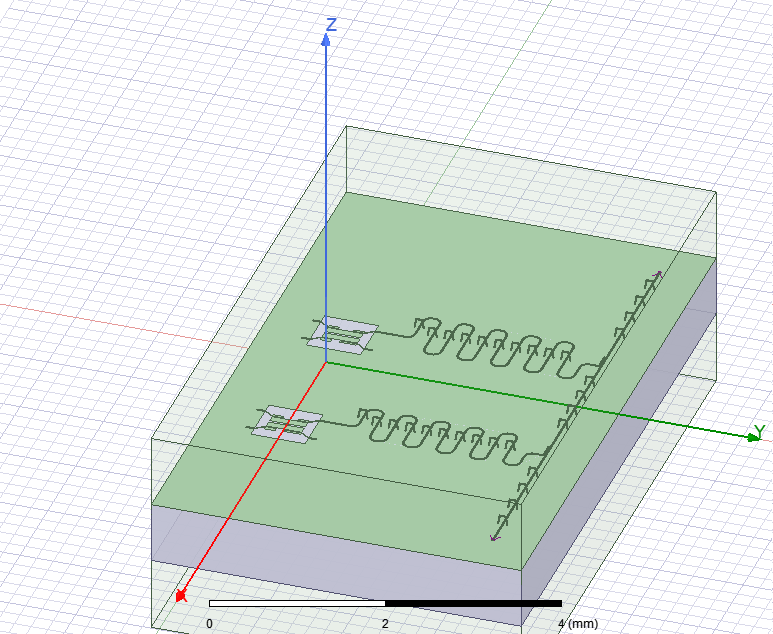

In [14]:
hfss.save_screenshot()

In [15]:
hfss.add_sweep(setup_name="Setup", 
               name="Sweep", 
               start_ghz=4.0,
               stop_ghz=8.0,
               count=2001,
               type="Interpolating")

INFO 04:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)


In [16]:
hfss.analyze_sweep('Sweep', 'Setup')

INFO 04:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 04:10PM [analyze]: Analyzing setup Setup : Sweep


Plot S, Y, and Z parameters as a function of frequency. <br>
The left and right plots display the magnitude and phase, respectively.

In [17]:
hfss.plot_params(['S11', 'S21'])

(                      S11                 S21
 4.000 -0.143098-0.048848j -0.272540+0.950189j
 4.002 -0.143154-0.048771j -0.271933+0.950358j
 4.004 -0.143211-0.048693j -0.271326+0.950527j
 4.006 -0.143267-0.048615j -0.270719+0.950696j
 4.008 -0.143324-0.048537j -0.270112+0.950864j
 ...                   ...                 ...
 7.992 -0.062410+0.067162j  0.836098+0.540865j
 7.994 -0.062323+0.067135j  0.836453+0.540328j
 7.996 -0.062236+0.067107j  0.836809+0.539791j
 7.998 -0.062149+0.067080j  0.837164+0.539254j
 8.000 -0.062062+0.067052j  0.837518+0.538717j
 
 [2001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [18]:
hfss.plot_params(['Y11', 'Y21'])

(                      Y11                 Y21
 4.000  0.000000-0.006621j -0.000000-0.024401j
 4.002  0.000000-0.006604j  0.000000-0.024396j
 4.004  0.000000-0.006588j  0.000000-0.024392j
 4.006  0.000000-0.006571j  0.000000-0.024387j
 4.008  0.000000-0.006555j  0.000000-0.024383j
 ...                   ...                 ...
 7.992  0.000000+0.037784j -0.000000-0.043977j
 7.994  0.000000+0.037838j -0.000000-0.044023j
 7.996  0.000000+0.037893j -0.000000-0.044068j
 7.998  0.000000+0.037947j -0.000000-0.044114j
 8.000  0.000000+0.038002j -0.000000-0.044159j
 
 [2001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [19]:
hfss.plot_params(['Z11', 'Z21'])

(                       Z11                  Z21
 4.000 -0.000000-12.731355j  0.000000+44.436662j
 4.002 -0.000001-12.701757j  0.000003+44.428324j
 4.004 -0.000003-12.672170j  0.000006+44.420007j
 4.006 -0.000004-12.642595j  0.000009+44.411712j
 4.008 -0.000005-12.613030j  0.000011+44.403438j
 ...                    ...                  ...
 7.992 -0.000015+65.018688j -0.000010+78.601319j
 7.994 -0.000012+65.110464j -0.000008+78.679344j
 7.996 -0.000008+65.202423j -0.000005+78.757556j
 7.998 -0.000004+65.294563j -0.000003+78.835955j
 8.000 -0.000000+65.386887j -0.000000+78.914542j
 
 [2001 rows x 2 columns],
 <Figure size 3000x1800 with 2 Axes>)

In [20]:
hfss.disconnect_ansys()

In [21]:
gui.main_window.close()

True